In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, transpile
from qiskit_aer import Aer
import itertools




In [ ]:
simulator = Aer.get_backend('aer_simulator_statevector')

In [ ]:
n = 7

In [ ]:
import random
num_clauses = np.random.randint(3, 3*n)  # Random number of clauses between 3 and 10


def random_boolean_function(num_vars, num_clauses, clause_size_range=(2, n)):
    """
    Generate a random Boolean function in CNF form.

    Args:
        num_vars (int): Number of variables.
        num_clauses (int): Number of clauses.
        clause_size_range (tuple): Min and max size of each clause.

    Returns:
        list of list of int: CNF clauses.
    """
    clauses = []
    for _ in range(num_clauses):
        clause_size = random.randint(*clause_size_range)
        vars_in_clause = random.sample(range(1, num_vars + 1), clause_size)
        clause = [var if random.choice([True, False]) else -var for var in vars_in_clause]
        clauses.append(clause)
    return clauses



In [ ]:

Bfunc = random_boolean_function(n, num_clauses)
print("Random Bfunc:", Bfunc)

Random Bfunc: [[4, 1, 7, -6], [4, -7, -6, -2, 5, 3], [2, -6, 3, -4, 5, -1], [-5, -3, -6, 1], [-4, -2, 3, 1], [6, -7, 4, 5, 2], [2, 7, 3, 1, -4], [2, 7]]


In [ ]:
# Remove duplicate clauses (ignoring order and sign)
seen = set()
unique_Bfunc = []
for clause in Bfunc:
    key = tuple(sorted(clause))
    if key not in seen:
        seen.add(key)
        unique_Bfunc.append(clause)
Bfunc = unique_Bfunc

In [ ]:
def sort_cnf_clauses(clauses):
    """
    Sorts a list of CNF clauses for easier readability:
    - Each clause is sorted by the absolute value of its literals.
    - The list of clauses is sorted first by the sorted absolute values of literals,
      then by the length of each clause.

    Args:
        clauses (list of list of int): The CNF clauses.

    Returns:
        list of list of int: The sorted CNF clauses.
    """
    # Sort literals within each clause by absolute value
    for clause in clauses:
        clause.sort(key=lambda literal: abs(literal))
    # Sort clauses by their sorted absolute literals, then by length
    clauses.sort(key=lambda clause: (sorted([abs(lit) for lit in clause]), len(clause)))
    clauses.sort(key=lambda x: len(x))
    return clauses

# Example usage:
Bfunc = sort_cnf_clauses(Bfunc)
print("Bfunc:", Bfunc)

Bfunc: [[2, 7], [1, -2, 3, -4], [1, -3, -5, -6], [1, 4, -6, 7], [1, 2, 3, -4, 7], [2, 4, 5, 6, -7], [-1, 2, 3, -4, 5, -6], [-2, 3, 4, 5, -6, -7]]


In [ ]:
def clause_circ(clause, ancilla_reg, circuit):
    """
    Marks the states that satisfy a given clause using an ancilla qubit.

    Args:
        clause (list of int): Clause as a list of literals (positive for variable, negative for negation).
        ancilla_reg (AncillaRegister): Ancilla register (at least one qubit).
        circuit (QuantumCircuit): The quantum circuit to modify.

    Steps:
    - Reset the ancilla qubit.
    - For each positive literal, apply X to flip the control to |1⟩.
    - Apply a multi-controlled X (MCX) gate with all clause qubits as controls and the ancilla as target.
    - Undo the X gates on positive literals.
    """
    circuit.reset(ancilla_reg[0])

    # Flip positive literals so all controls are on |1>
    for literal in clause:
        if literal > 0:
            circuit.x(abs(literal) - 1)

    # Controls are the absolute variable indices minus 1 (0-based)
    control_qubits = [abs(literal) - 1 for literal in clause]
    circuit.mcx(control_qubits, ancilla_reg[0])

    # Undo the X gates on positive literals
    for literal in clause:
        if literal > 0:
            circuit.x(abs(literal) - 1)

In [ ]:
def intersection(clause1, clause2, processed_literals, current_literal_idx, applied_clauses, intersection_queue):
    """
    Finds an intersection between two clauses for SAT solving.

    Args:
        clause1 (list): The current clause being processed.
        clause2 (list): Another clause to check for intersection.
        processed_literals (list): List of literals processed so far.
        current_literal_idx (int): Index of the current literal in clause1.
        applied_clauses (list): List of clauses already applied/intersected.
        intersection_queue (list): Queue/list of intersections for the current clause.

    Returns:
        list or None or int: Returns a pair [index, clause] if a valid intersection is found,
        None if no intersection is possible, or -1 if intersection is invalid.
    """
    # Create a copy of clause2 with unique absolute literals
    unique_clause2 = []
    for literal in clause2:
        if abs(literal) not in np.abs(unique_clause2):
            unique_clause2.append(literal)

    # Check for direct intersection: literal in both processed_literals and clause2, and clause2 not already applied
    for literal in clause2:
        if literal in processed_literals and clause2 not in applied_clauses:
            return [abs(literal) - 1, unique_clause2]

    # Prepare the next literal to check
    next_literal = current_literal_idx + 1
    if next_literal not in clause2:
        next_literal = -next_literal

    # Check for intersection with already applied clauses
    for idx, applied_clause in enumerate(applied_clauses):
        if applied_clause == clause2:
            for literal in clause2:
                if literal != intersection_queue[idx][0] and not (abs(literal) in np.abs(processed_literals) and literal not in processed_literals):
                    return [abs(literal) - 1, unique_clause2]

    # If next_literal is not in processed_literals, return it as intersection
    if abs(next_literal) not in np.abs(processed_literals):
        return [abs(next_literal) - 1, unique_clause2]

    # Otherwise, return the first literal in clause2 not in processed_literals
    for literal in clause2:
        if abs(literal) not in np.abs(processed_literals):
            return [abs(literal) - 1, unique_clause2]


In [ ]:
def find_intersections(current_clause, current_literal, previous_clauses, recursion_count, intersection_queue, applied_queue, num_vars, depth=0, processed_literals=0, applied_clauses=None):
    """
    Recursively finds intersections between clauses to build a queue of intersecting literals and clauses.

    Args:
        current_clause (list): The clause currently being processed.
        current_literal (int): The literal currently being considered.
        previous_clauses (list): List of previous clauses (subset of all clauses).
        recursion_count (int): Counter for recursion or tracking (not always used).
        intersection_queue (list): Queue/list of intersections for the current clause.
        applied_queue (list): List of applied/intersected clauses so far.
        num_vars (int): Number of variables.
        depth (int, optional): Depth or recursion flag (default 0).
        processed_literals (list or int, optional): List of literals processed so far (default 0, which is replaced by [current_literal]).
        applied_clauses (list, optional): List of clauses already applied/intersected (default None).

    Returns:
        tuple: (intersection_queue, applied_clauses) - Updated queue of intersections and applied clauses.
    """
    if processed_literals == 0:
        processed_literals = [current_literal]
    if applied_clauses is None:
        applied_clauses = [current_clause]

    if len(processed_literals) > num_vars:
        print('out of range', 'current_clause', current_clause, 'current_literal', current_literal, 'processed_literals', processed_literals, 'intersection_queue', intersection_queue)
        return intersection_queue, applied_clauses

    for idx, prev_clause in enumerate(previous_clauses):
        if idx >= len(applied_queue):
            break
        for literal in prev_clause:
            # Look for opposite sign of the same variable in a different clause
            if (abs(literal) == abs(current_literal) and literal != current_literal and current_clause != prev_clause):
                intersection_result = intersection(current_clause, prev_clause, processed_literals, applied_queue[idx][1][0], applied_clauses, intersection_queue)
                if intersection_result is None:
                    intersection_queue[0] = -len(applied_queue) - 1
                    return intersection_queue, applied_clauses
                if intersection_result == -1 or intersection_result in intersection_queue:
                    continue
                applied_clauses.append(prev_clause)
                intersection_queue[0] += 1
                intersection_queue.append(intersection_result)

                # Prepare next literal to process
                next_literal = intersection_result[0] + 1
                if next_literal not in intersection_result[1]:
                    next_literal = -next_literal

                alt_literal = applied_queue[idx][1][0] + 1
                if alt_literal not in intersection_result[1]:
                    alt_literal = -alt_literal

                # Recurse if next_literal not already processed
                if next_literal not in processed_literals:
                    processed_literals.append(next_literal)
                    intersection_queue, applied_clauses = find_intersections(
                        prev_clause, processed_literals[-1], previous_clauses, recursion_count,
                        intersection_queue, applied_queue, num_vars, depth=depth+1,
                        processed_literals=processed_literals, applied_clauses=applied_clauses
                    )
                else:
                    intersection_queue, applied_clauses = find_intersections(
                        prev_clause, next_literal, previous_clauses, recursion_count,
                        intersection_queue, applied_queue, num_vars, depth=depth+1,
                        processed_literals=processed_literals, applied_clauses=applied_clauses
                    )
                break

    return intersection_queue, applied_clauses


In [ ]:
def find_min(sublist_collection, max_value=1000):
    """
    Find the sublist in sublist_collection with the minimal positive first element.

    Args:
        sublist_collection (list of lists): Each sublist starts with an integer (typically a cost or marker).
        max_value (int, optional): Upper bound for the minimum search (default 1000).

    Returns:
        list: The sublist from sublist_collection with the smallest positive first element, or an empty list if none found.
    """
    min_first_elem = max_value
    min_sublist = []
    for sublist in sublist_collection:
        if sublist[0] >= 1 and sublist[0] < min_first_elem:
            min_first_elem = sublist[0]
            min_sublist = sublist
            if min_first_elem == 1:
                break
    return min_sublist


In [ ]:
def Sat_solver(clauses, num_vars):
    """
    Quantum SAT Solver: Constructs a quantum circuit to solve a Boolean SAT problem in CNF form.

    Args:
        clauses (list of list of int): The Boolean function in CNF, where each clause is a list of literals.
        num_vars (int): Number of variables.

    Returns:
        tuple: (QuantumCircuit, complexity, cx_count)
            - QuantumCircuit: The constructed quantum circuit for the SAT problem.
            - complexity: The sum of minimal intersections per clause (or None if unsatisfiable).
            - cx_count: The number of CX gates applied (as a measure of circuit complexity).
    """
    qr = QuantumRegister(num_vars, 'q')
    cr = ClassicalRegister(num_vars, 'c')
    anc = AncillaRegister(1, 'anc')
    qc = QuantumCircuit(qr, cr, anc)

    qc.h(qr)  # Apply Hadamard to all variables

    intersection_info = []
    complexity = 1
    cx_count = 0

    for clause_idx, clause in enumerate(clauses):
        clause_intersections = [[-1 - num_vars] for _ in range(num_vars)]

        for literal in clause:
            var_idx = abs(literal) - 1
            clause_intersections[var_idx].append([var_idx, clause])
            clause_intersections[var_idx][0] = 1
            if intersection_info == []:
                break
            clause_intersections[var_idx] = find_intersections(
                clause, literal, clauses[:clause_idx], cx_count,
                clause_intersections[var_idx], intersection_info, num_vars,
                depth=0, processed_literals=0, applied_clauses=None
            )[0]
            if clause_intersections[var_idx][0] == 1:
                break

        intersection_info.append(find_min(clause_intersections))
        if intersection_info[-1] == []:
            for item in clause_intersections:
                if len(item) > 1:
                    intersection_info[-1] = item
                    break
            if intersection_info[-1] == []:
                print('No solution found')
                complexity = None

        if complexity is not None:
            for intersect in intersection_info[-1][1:]:
                clause_circ(intersect[1], anc, qc)  # Mark the states using ancilla
                qc.cx(anc[0], intersect[0])         # Remove the marked states
                cx_count += 1
        qc.barrier()

    qc.measure(qr, cr)
    print('Intersections info:', intersection_info)
    if complexity is not None:
        complexity = sum(item[0] for item in intersection_info)
    print('Complexity:', complexity)
    print('CX gate count:', cx_count)
    return qc, complexity, cx_count


In [ ]:
sol=Sat_solver(Bfunc, n)
circ=sol[0]
complexity=sol[1]
cxcount=sol[2]
print(Bfunc)
# circ.draw('mpl')

Intersections info: [[1, [1, [2, 7]]], [1, [0, [1, -2, 3, -4]]], [1, [0, [1, -3, -5, -6]]], [1, [0, [1, 4, -6, 7]]], [1, [0, [1, 2, 3, -4, 7]]], [2, [1, [2, 4, 5, 6, -7]], [0, [1, -2, 3, -4]]], [2, [1, [-1, 2, 3, -4, 5, -6]], [0, [1, -2, 3, -4]]], [3, [2, [-2, 3, 4, 5, -6, -7]], [0, [1, -3, -5, -6]], [2, [-1, 2, 3, -4, 5, -6]]]]
Complexity: 12
CX gate count: 12
[[2, 7], [1, -2, 3, -4], [1, -3, -5, -6], [1, 4, -6, 7], [1, 2, 3, -4, 7], [2, 4, 5, 6, -7], [-1, 2, 3, -4, 5, -6], [-2, 3, 4, 5, -6, -7]]


{'1101101': 6, '1001001': 2, '1110010': 5, '1111011': 15, '1001101': 7, '0000111': 18, '0010010': 11, '1001100': 8, '1011111': 4, '1111001': 6, '0000011': 16, '1101110': 5, '1110001': 9, '0111111': 32, '1011100': 9, '0010111': 17, '1011110': 12, '1101111': 9, '1110101': 14, '0110011': 31, '1000111': 19, '1010100': 14, '0100111': 25, '1010000': 10, '0011011': 37, '1110011': 10, '0001110': 16, '1101011': 23, '1011001': 7, '1010010': 7, '0100011': 30, '0011111': 14, '1000110': 16, '0101111': 21, '1000011': 23, '1001011': 16, '1100101': 7, '1100110': 17, '1011101': 3, '0000010': 16, '0010110': 16, '0101110': 19, '1110111': 13, '0101011': 27, '1010011': 12, '1010110': 10, '0110111': 28, '0111011': 38, '0001011': 42, '0011110': 18, '1010101': 7, '1101000': 11, '1000010': 9, '1111111': 10, '0010011': 17, '1011011': 12, '1001000': 7, '1100111': 8, '1001110': 5, '0001111': 8, '1101100': 12, '1100001': 10, '1010111': 9, '1110000': 12, '1011000': 7, '0000110': 16, '1111000': 9, '1111101': 12, '10

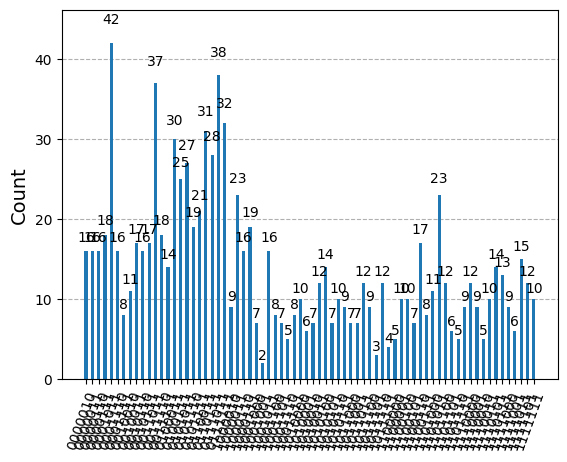

In [ ]:
circuit = transpile(circ, simulator)
job = simulator.run(circuit, shots=1000)
result = job.result()

counts = result.get_counts()
print(counts)
sorted_counts = dict(sorted(result.get_counts().items()))
print(sorted_counts)

from qiskit.visualization import plot_histogram
print("Number of unique outcomes:", len(counts))
print('complexity:', complexity)
# Plot the histogram of the counts
plot_histogram(counts)


In [ ]:


def is_satisfiable(clauses, num_vars):
    """
    Find all satisfying assignments for a Boolean SAT problem in CNF.

    Args:
        clauses (list of list of int): Each clause is a list of integers, where
            positive means the variable, negative means its negation.
        num_vars (int): Number of variables.

    Returns:
        list of str: Each string is a satisfying assignment as a bitstring.
    """
    solutions = []
    for assignment in itertools.product([False, True], repeat=num_vars):
        satisfied = True
        for clause in clauses:
            clause_satisfied = False
            for literal in clause:
                var_idx = abs(literal) - 1
                value = assignment[var_idx]
                if (literal > 0 and value) or (literal < 0 and not value):
                    clause_satisfied = True
                    break
            if not clause_satisfied:
                satisfied = False
                break
        if satisfied:
            bitstring = ''.join(str(int(bit)) for bit in assignment)
            solutions.append(bitstring)
    return solutions



In [ ]:
s = is_satisfiable(Bfunc, n)
# s, len(s)

In [ ]:
# Convert s (list of solutions) to bitstrings
s_bitstrings = set(bitstring[::-1] for bitstring in s)

# Keys present in counts but not in s
counts_keys = set(counts.keys())
diff_counts_not_in_s = counts_keys - s_bitstrings

# Keys present in s but not in counts
diff_s_not_in_counts = s_bitstrings - counts_keys

print("Counts keys :", sorted(counts_keys))
print("S bitstrings :", sorted(s_bitstrings))
print("Keys in counts but not in s:", diff_counts_not_in_s)
print("Keys in s but not in counts:", diff_s_not_in_counts)
print('num_clauses', len(Bfunc), 'complexity:', complexity)
print(Bfunc)
print(len(counts_keys), len(s_bitstrings))
# if complexity is not None:
print("Complexity per clause:", cxcount / len(Bfunc))
# else:
#     print(None)
len(diff_counts_not_in_s), len(diff_s_not_in_counts), complexity


Counts keys : ['0000010', '0000011', '0000110', '0000111', '0001011', '0001110', '0001111', '0010010', '0010011', '0010110', '0010111', '0011011', '0011110', '0011111', '0100011', '0100111', '0101011', '0101110', '0101111', '0110011', '0110111', '0111011', '0111111', '1000010', '1000011', '1000110', '1000111', '1001000', '1001001', '1001011', '1001100', '1001101', '1001110', '1001111', '1010000', '1010001', '1010010', '1010011', '1010100', '1010101', '1010110', '1010111', '1011000', '1011001', '1011011', '1011100', '1011101', '1011110', '1011111', '1100000', '1100001', '1100100', '1100101', '1100110', '1100111', '1101000', '1101011', '1101100', '1101101', '1101110', '1101111', '1110000', '1110001', '1110010', '1110011', '1110101', '1110111', '1111000', '1111001', '1111011', '1111101', '1111111']
S bitstrings : ['0000010', '0000011', '0000110', '0000111', '0001011', '0001110', '0001111', '0010010', '0010011', '0010110', '0010111', '0011011', '0011110', '0011111', '0100011', '0100111', '

(0, 0, 12)